In [7]:
import ultralytics
from ultralytics import YOLO
import os
import math
from PIL import Image
import cv2
from IPython.display import Video
import glob
import matplotlib.pyplot as plt
import numpy as np

import board.corners as corners

import warnings
warnings.filterwarnings("ignore")


image 1/1 c:\Users\Gebruiker\Desktop\School\Extended Reality\ChessAR_final\ChessAR\images\test_images\img_2.jpg: 640x480 4 corners, 19.0ms
Speed: 5.0ms preprocess, 19.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


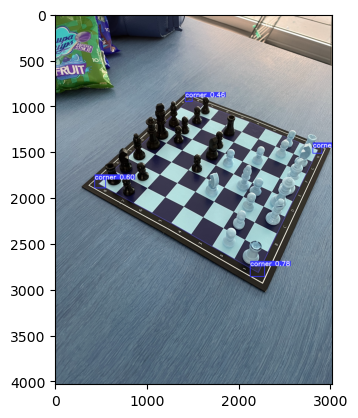

In [8]:
corners_model = YOLO('models/corners2.pt')
img_path = 'images/test_images/img_2.jpg'

#error
# img_path = 'C:/Users/Gebruiker/Downloads/jpg/20240428_125612269_iOS.jpg'

# img = Image.open(img_path)
# plt.imshow(img)
# plt.title('Original Image')
# plt.show()

results = corners.predict_corners(corners_model, img_path, confidence_threshold=0.25, iou_threshold=0.1)

image_corners = results[0].plot(line_width=7, font_size=15)
plt.imshow(image_corners)
plt.show()

# print(corners.box_coordinates(results))


[(490.77222, 1849.3972), (1530.691, 929.28754), (2853.2627, 1425.0109), (2357.8357, 2688.8635)]


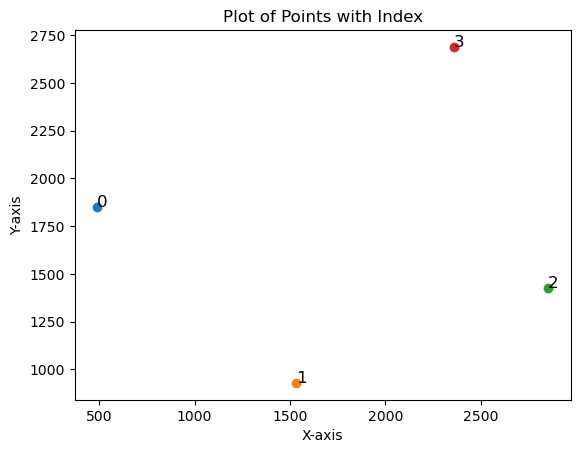

{'top-left': (490.77222, 1849.3972), 'top-right': (2357.8357, 2688.8635), 'bottom-right': (2853.2627, 1425.0109), 'bottom-left': (1530.691, 929.28754)}
sorted correct:  [(1530.691, 929.28754), (2853.2627, 1425.0109), (2357.8357, 2688.8635), (490.77222, 1849.3972)]
sorted:  [(1230.6910400390625, 629.2875366210938), (3153.2626953125, 1125.0108642578125), (2657.835693359375, 2988.863525390625), (190.772216796875, 2149.397216796875)]


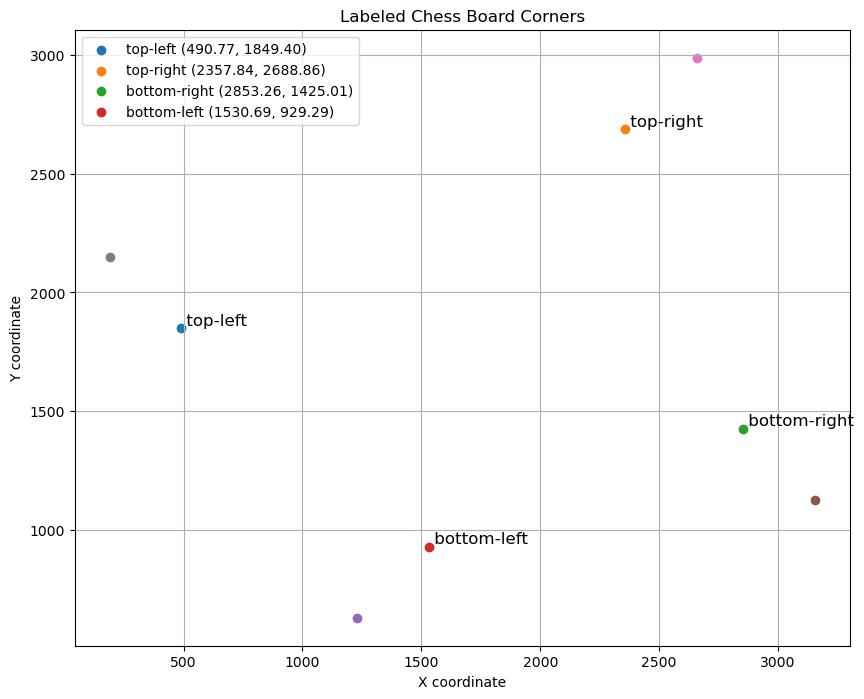

In [9]:
sorted_corners = corners.get_corner_coordinates(results, offsetx=250, offsety=250)
print(sorted_corners)

# Plot the points and label them with their index
for (i,point) in enumerate(sorted_corners):
    plt.scatter(point[0], point[1])
    plt.text(point[0], point[1], str(i), fontsize=12)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of Points with Index')

# Show the plot
plt.show()

# label corners
labeled_corners, sorted_c = corners.label_and_sort_corners(sorted_corners)
print(labeled_corners)
print("sorted correct: ", sorted_c)

# Plotting
plt.figure(figsize=(10, 8))
for label, (x, y) in labeled_corners.items():
    plt.scatter(x, y, label=f'{label} ({x:.2f}, {y:.2f})')  # Plot each corner with a label
    plt.text(x, y, f' {label}', fontsize=12, verticalalignment='bottom')  # Add text labels to the plot

# Add offset
sorted_c = corners.add_offset(sorted_c, offsetx=300, offsety=300)
print("sorted: ", sorted_c)
# Plot the points and label them with their index
for (x, y) in sorted_c:
    plt.scatter(x, y)
    # plt.text(point[0], point[1], str(i), fontsize=12)

plt.title('Labeled Chess Board Corners')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Equal scaling of x and y axes
plt.show()






In [10]:
# load image
image = cv2.imread(img_path)

# Suppose corners are in the format [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
# and are ordered as [top-left, top-right, bottom-right, bottom-left]
# corners1 = np.array(sorted_corners, dtype="float32")
corners1 = np.array(sorted_c, dtype="float32")

# Define the dimensions of the window where the new image will be displayed
dimension = 640  # Set this to what fits your needs, maybe 300x300 or 400x400 pixels
margin = 0

# The destination points are the points of the new image (a perfect square)
dst = np.array([
    [0, 0],
    [dimension - 1 - margin, margin],
    [dimension - 1 - margin, dimension - 1 - margin],
    [margin, dimension - 1 - margin]
], dtype="float32")
# Compute the perspective transform matrix and apply it
M = cv2.getPerspectiveTransform(corners1, dst)
warped = cv2.warpPerspective(image, M, (dimension, dimension))
# Resize the warped image for display
resized_warped_image = cv2.resize(warped, (800, 600))

# Display the result
cv2.imshow('Warped Image', warped)
# cv2.imwrite('images/warped_image.jpg', warped)
cv2.waitKey(0)
cv2.destroyAllWindows()

Test Segmentation

In [11]:
def sort_corners(corners):
    # Sort based on their x-coordinates
    corners = sorted(corners, key=lambda x: x[0])
    
    # Separate them into leftmost and rightmost
    left_most = corners[:2]
    right_most = corners[2:]

    # Within each pair, sort them by y-coordinate to separate top from bottom
    left_most = sorted(left_most, key=lambda x: x[1])
    right_most = sorted(right_most, key=lambda x: x[1])

    # The coordinates are now sorted in the following order:
    # top-left, bottom-left, top-right, bottom-right
    sorted_corners = np.array([left_most[0], right_most[0], right_most[1], left_most[1]])

    return sorted_corners


0: 640x640 1 board-8fSi, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


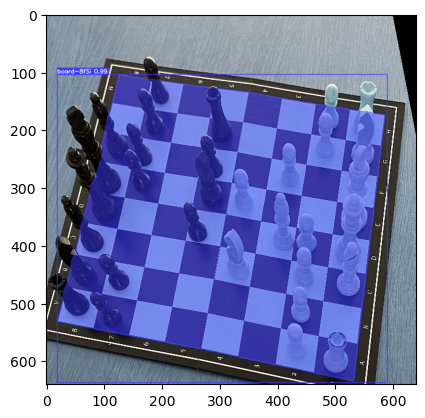

gets here
[[        124         109]
 [        586         175]
 [        531         634]
 [         21         531]]


In [12]:
seg_model = YOLO('models/segment_grid.pt')
results = seg_model.predict(warped, conf=0.1, iou=0.2)

test_image = results[0].plot(line_width=1, font_size=12)
plt.imshow(test_image)
plt.show()

# Access segmentation masks
masks = results[0].masks
contour_points = masks.xy[0]
contour_points = np.array(contour_points)

leftmost = tuple(contour_points[contour_points[:, 0].argmin()])
rightmost = tuple(contour_points[contour_points[:, 0].argmax()])
topmost = tuple(contour_points[contour_points[:, 1].argmin()])
bottommost = tuple(contour_points[contour_points[:, 1].argmax()])

# Use OpenCV to approximate the contour to a polygon
epsilon = 0.1 * cv2.arcLength(contour_points, True)
approx_corners = cv2.approxPolyDP(contour_points, epsilon, True)

if len(approx_corners) == 4:
    approx_corners = approx_corners.reshape((4, 2))
    # Sort the corners into the order you need for perspective transformation
    print("gets here")
    sorted_corners = sort_corners(approx_corners)
else:
    raise Exception("Couldn't approximate a quadrilateral. Check the segmentation.")

# Draw the corners on the image to verify
for corner in sorted_corners:
    cv2.circle(warped, tuple(int(x) for x in corner), 5, (255, 0, 0), -1)

print(sorted_corners)
cv2.imshow('Chessboard Corners', warped)
cv2.waitKey(0)
cv2.destroyAllWindows()